## **과거 데이터를 기반으로 기후 예측하기**

RNN은 단순히 텍스트 분석 뿐만 아니라, sequence를 가지는 모든 데이터에 적용 가능하다.

#### **[상식 수준의 기준점]**
* 앞으로 만들 딥러닝 모델의 성능을 측정할 수 있는 기준점이 필요하다. 따라서, 상식 수준의 기준점을 계산해 주는 간단한 함수를 작성하는 것이 좋다. 여기서 계산할 날씨 데이터는 주기성을 가지므로, 그 주기성을 이용하여 기준점을 계산한다.

```python
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
```

#### **[순환 드롭아웃]**
* GRU, LSTM 같은 순환 게이트에 의해 만들어지는 표현을 규제하려면 순환 층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 한다. 모든 타임스텝에 동일한 드롭아웃 마스크를 적용하면 네트워크가 학습 오차를 타임스텝에 걸쳐 적절하게 전파시킬 것이다.

```python
R = GRU(32, 
        dropout = 0.1, # 입력 층의 드롭아웃
        recurrent_dropout = 0.5)(R) # 순환 층의 드롭아웃
```

#### **[스태킹 순환층]**
* 보통 모델을 만들 때, 과대적합이 일어날 때 까지 네트워크 용량을 늘리는 것이 좋다. 케라스에 순환층을 차례대로 쌓아서 네트워크 용량을 늘린다. 모든 중간층은 마지막 타임스텝 출력만 아니고 전체 시퀀스를 출력해야 한다.

```python
R = GRU(32, 
        dropout = 0.1, # 입력 층의 드롭아웃
        recurrent_dropout = 0.5
        return_sequences = True)(R) # 스태킹 순환층
```







Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


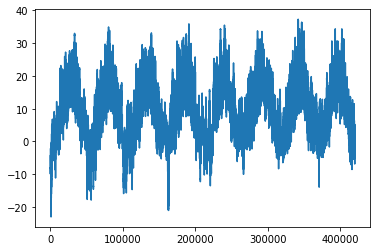

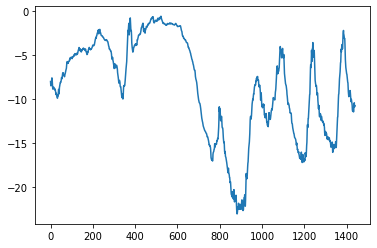

0.2897359729905486
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 13s 25ms/step - loss: 1.7683 - val_loss: 0.4713
Epoch 2/20
500/500 [==============================] - 12s 25ms/step - loss: 0.3875 - val_loss: 0.3195
Epoch 3/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2860 - val_loss: 0.3505
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2678 - val_loss: 0.3542
Epoch 5/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2531 - val_loss: 0.3482
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2446 - val_loss: 0.3525
Epoch 7/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2358 - val_loss: 0.3199
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2303 - val_loss: 0.3209
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2267 - val_loss: 0.3223
Epoch 10/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2217 - val_los

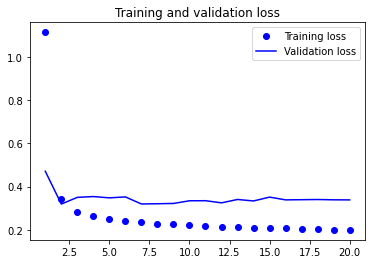

Epoch 1/20
500/500 [==============================] - 380s 753ms/step - loss: 0.3512 - val_loss: 0.2880
Epoch 2/20
500/500 [==============================] - 382s 765ms/step - loss: 0.3084 - val_loss: 0.2749
Epoch 3/20
500/500 [==============================] - 382s 764ms/step - loss: 0.2974 - val_loss: 0.2842
Epoch 4/20
500/500 [==============================] - 382s 765ms/step - loss: 0.2895 - val_loss: 0.2691
Epoch 5/20
500/500 [==============================] - 383s 765ms/step - loss: 0.2848 - val_loss: 0.2706
Epoch 6/20
500/500 [==============================] - 382s 764ms/step - loss: 0.2776 - val_loss: 0.2664
Epoch 7/20
500/500 [==============================] - 381s 763ms/step - loss: 0.2737 - val_loss: 0.2893
Epoch 8/20
500/500 [==============================] - 382s 765ms/step - loss: 0.2676 - val_loss: 0.2794
Epoch 9/20
500/500 [==============================] - 382s 765ms/step - loss: 0.2641 - val_loss: 0.2877
Epoch 10/20
500/500 [==============================] - 382s 763m

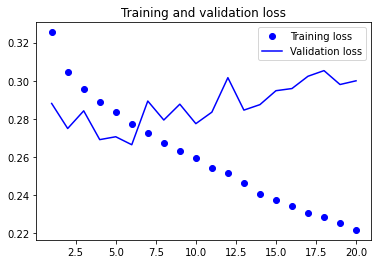

In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Embedding, GRU
from tensorflow.keras.optimizers import RMSprop
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/jena_climate_2009_2016.csv.zip (Unzipped Files)'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp) # 데이터 그래프로 표시하기
plt.show()

plt.figure()
plt.plot(range(1440), temp[:1440])
plt.show()

mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback

  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i+batch_size, max_index))
      i += len(rows)
    
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, 
                      lookback = lookback, 
                      delay = delay, 
                      min_index = 0, 
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_gen = generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 200001,
                    max_index = 300000,
                    step = step,
                    batch_size = batch_size)

test_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     step = step,
                     batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 상식 수준의 기준점을 만든다. 딥러닝 모델의 성능을 평가하는 기준이 된다.
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

# RNN을 사용하지 않은 기본적인 머신러닝 방법
input = Input(shape = (lookback // step, float_data.shape[-1]))
R = Flatten()(input)
R = Dense(32)(R)
R = Activation('relu')(R)
R = Dense(1)(R)
model = Model(inputs = [input], outputs = R)

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# GRU 순환층과 순환 드로바웃
input = Input(shape = (None, float_data.shape[-1],))
R = GRU(32,
        dropout = 0.1,
        recurrent_dropout = 0.5, # 순환 드롭아웃 적용
        return_sequences = True)(input) # 스태킹 순환 층
R = GRU(64,
        dropout = 0.1,
        recurrent_dropout = 0.5)(R)
R = Dense(1)(R)

model = Model(inputs = [input], outputs = R)
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

